In [1]:
import glob
import joblib

In [2]:
from utils import convert_episodes_to_traj_class

In [3]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

In [4]:
from decision_bias_analysis_tools import ComputeFourBiasClips2
from parameters import EXPLORE, HOME_NODE, UnrewNamesSub
import evaluation_metrics as em

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.size"] = 18

In [6]:
def load(model_name):
    if model_name == 'Animals':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-tf') for _ in UnrewNamesSub]
        return tfs

    if model_name == 'BiasedWalk':
        tfs = [LoadTrajFromPath(f'../outdata/{_}-RW5-tf') for _ in UnrewNamesSub]
        return tfs
    
    if model_name == 'RandomWalk':
        tfs = [LoadTrajFromPath('../outdata/rw01-tf')]
        return tfs
    
    if model_name == 'MarkovChain':
        tfs = [LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{_}-MarkovSim-tf') for _ in UnrewNamesSub]
        return tfs

    tfs = []
    for f in glob.glob(f'/Users/us3519/mouse-maze/figs/may28/{model_name}/MAX_LENGTH=50000/**/episodes_*.pkl'):
        s = joblib.load(f)
        tf = convert_episodes_to_traj_class(s["episodes_positions"], s["episodes_states"])
        tfs.append(tf)
    return tfs

In [7]:
def get_biases(tfs):
    bi = np.array([ComputeFourBiasClips2(tf,ma,SplitModeClips(tf,ma),mode=EXPLORE)[0] for tf in tfs]) # bias using exploration only
    return bi

In [8]:
ma=NewMaze()

In [9]:
bi_altoptions = get_biases(load('TeAltOptions'))

In [10]:
bi_biasedwalk = get_biases(load('BiasedWalk'))

In [11]:
bi_markov = get_biases(load('MarkovChain'))

In [12]:
bi_animals = get_biases(load('Animals'))

In [13]:
bi_randomwalk = np.array([[2/3, 1/2, 2/3, 1/2]])

In [14]:
model_colors = {
    'Animals': 'r',
    'TeAltOptions': 'k',
    'BiasedWalk': 'b',
    'MarkovChain': 'm',
    'RandomWalk': 'g',
    'Optimal': 'k:',
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


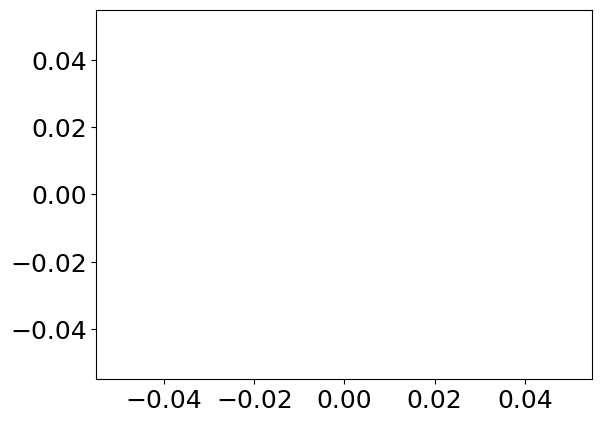

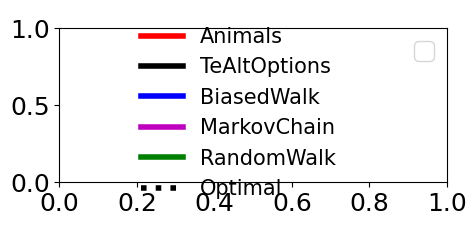

In [15]:
# reate a dummy plot to get legend handles
fig, ax = plt.subplots()
lines = []

for model_name in model_colors:
    lines.append(ax.plot([], [], model_colors[model_name], linewidth=4, label=model_name)[0])

fig_legend = plt.figure(figsize=(5, 2))
fig_legend.legend(handles=lines, labels=[line.get_label() for line in lines], fontsize='small', loc='center', frameon=False)
fig_legend.tight_layout()
fig_legend.savefig('../../figs/paper figs/figure_results/legend_only.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.legend()
plt.show()  # it saves the correct legend but does not show in jupyter notebook

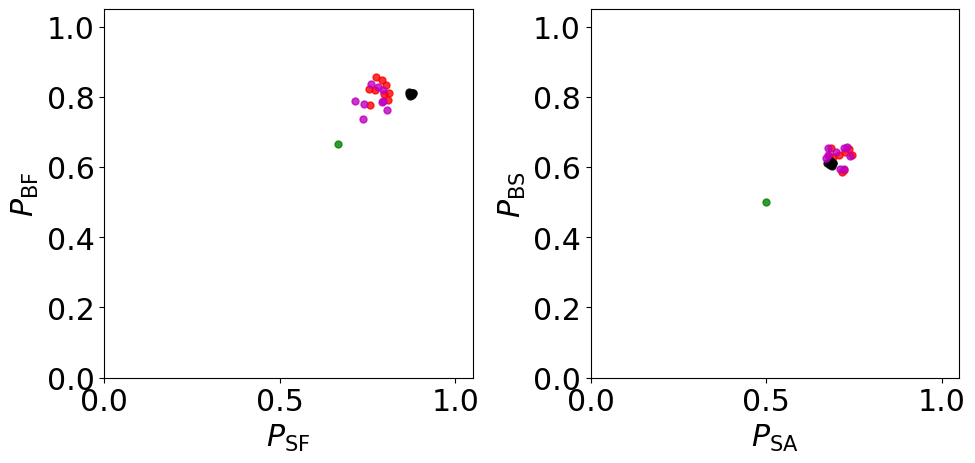

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot([bi_animals[:,0], bi_randomwalk[:,0], bi_altoptions[:,0], bi_markov[:,0]],
     [bi_animals[:,2], bi_randomwalk[:,2], bi_altoptions[:,2], bi_markov[:,2]],
     fmts=['r.', 'g.', 'k.', 'm.'], markersize=10, alpha=0.8, xlim=[0,1.05], ylim=[0,1.05], equal=True, axes=ax[0],
    )

plot([bi_animals[:,1], bi_randomwalk[:,1], bi_altoptions[:,1], bi_markov[:,1]],
     [bi_animals[:,3], bi_randomwalk[:,3], bi_altoptions[:,3], bi_markov[:,3]],
     fmts=['r.', 'g.', 'k.', 'm.'], markersize=10, alpha=0.8, xlim=[0,1.05], ylim=[0,1.05],equal=True, axes=ax[1])


ax[0].set_xlabel('$P_{\mathrm{SF}}$', fontsize='large')
ax[0].set_ylabel('$P_{\mathrm{BF}}$', fontsize='large')
ax[1].set_xlabel('$P_{\mathrm{SA}}$', fontsize='large')
ax[1].set_ylabel('$P_{\mathrm{BS}}$', fontsize='large')

for _ in ax:
    _.tick_params(axis='both', labelsize='large')


plt.tight_layout()
plt.savefig('../../figs/paper figs/figure_results/decisionbiases.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [17]:
def get_expeff(tfs, le=6):
    y_tfs = []
    for tf in tfs:
        wcn=NewNodesMerge3(tf,ma,le) 
        x=wcn[1]
        y=wcn[2]
        y_tfs.append(y)

    min_len = min(len(_) for _ in y_tfs)
    y_tfs = np.array([_[:min_len] for _ in y_tfs])  # some tfs might not have all window sizes
    y_mu = np.mean(y_tfs, axis=0)
    y_std = np.std(y_tfs, axis=0)
    return x[:min_len], y_mu, y_std

In [58]:
def get_markov_expeff(le=6):
    
    def MarkovEff4(nickname, le):
        '''
        Computes curve of new nodes vs all nodes from the Markov simulation of mouse nickname.
        '''
        tf=LoadTrajFromPath(f'../../Rosenberg-2021-Repository/outdata/{nickname}-MarkovSim-tf')
        da=tf.no[0][:-1,0] # the node sequence minus the exit state at the end
        ns=da[(da>=2**le-1) & (da<2**(le+1)-1)] # restrict the node sequence to the end nodes
        wcn=NewNodes4(ns) # compute new nodes vs all nodes
        return wcn

    y_tfs = []
    for nickname in UnrewNamesSub:
        wcn=MarkovEff4(nickname, le)
        x=wcn[1]
        y=wcn[2]
        y_tfs.append(y)

    min_len = min(len(_) for _ in y_tfs)
    y_tfs = np.array([_[:min_len] for _ in y_tfs])  # some tfs might not have all window sizes
    y_mu = np.mean(y_tfs, axis=0)
    y_std = np.std(y_tfs, axis=0)
    return x[:min_len], y_mu, y_std

Animals
TeAltOptions
BiasedWalk
MarkovChain
RandomWalk
Optimal


/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_20205/3952911936.py:38: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 3*1e3)


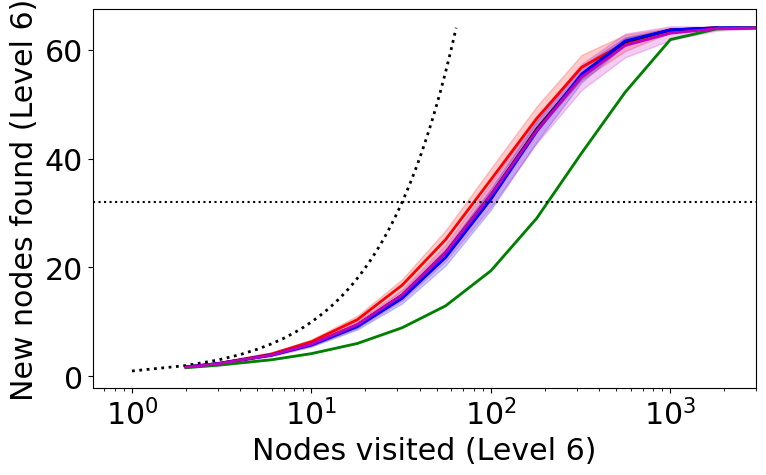

In [66]:
le=6

x_dfs=list(range(1, (2**le)+1))
y_dfs=list(range(1, (2**le)+1))

plt.figure(figsize=(8, 5.1))
ax = plt.gca()

legends = []
for model_name in model_colors:
    print(model_name)
    if model_name == 'MarkovChain':
        continue
    tfs = load(model_name)
    if not tfs: continue
    x, y_mu, y_std = get_expeff(tfs, le=le)
    plot(x, y_mu, fmts=[f"{model_colors[model_name]}-"],linewidth=2, axes=ax)
    legends.append(model_name)
    ax.fill_between(x, y_mu+y_std, y_mu-y_std, color=model_colors[model_name], alpha=0.2)
    legends.append('_')  # an empty legend for fill_between

plot(x_dfs,y_dfs,fmts=['k:'],axes=ax,linewidth=2);
legends.append('Optimal')

x, y_mu, y_std = get_markov_expeff(le=le)
plot(x, y_mu, fmts=[f"{model_colors['MarkovChain']}-"],linewidth=2, axes=ax)
legends.append('MarkovChain')
ax.fill_between(x, y_mu+y_std, y_mu-y_std, color=model_colors['MarkovChain'], alpha=0.2)
legends.append('_')  # an empty legend for fill_between

plt.axhline(2**(le-1), ls=':', c='k')
# plt.axhline(2**(le), ls=':', c='k')
# plt.legend(legends, loc='lower right', bbox_to_anchor=(2, 0.5), fontsize='small')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlabel(f'Nodes visited (Level {le})', fontsize='large')
ax.set_ylabel(f'New nodes found (Level {le})', fontsize='large')
plt.xscale('log')
plt.xlim(0, 3*1e3)
plt.tight_layout()
plt.savefig(f'../../figs/paper figs/figure_results/expeff_le={le}.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Animals
TeAltOptions
BiasedWalk
MarkovChain
RandomWalk
Optimal


/var/folders/yx/80nc9b6n4pg69y4hhtmkpw100000gp/T/ipykernel_20205/2705602753.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 3*1e3)


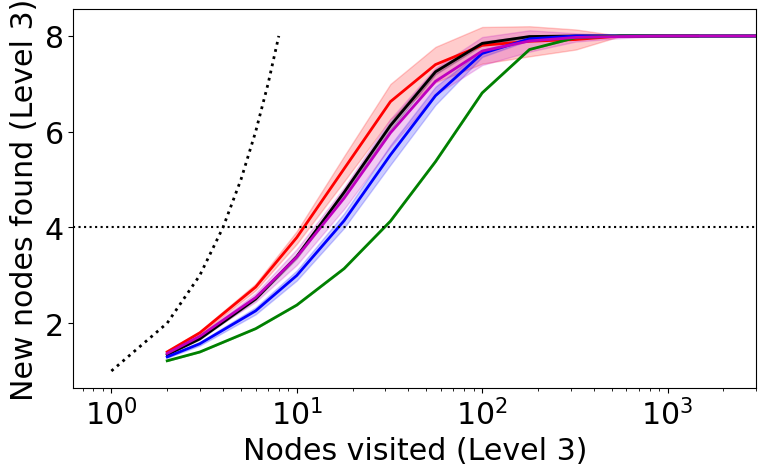

In [65]:
le=3

x_dfs=list(range(1, (2**le)+1))
y_dfs=list(range(1, (2**le)+1))

plt.figure(figsize=(8, 5.1))
ax = plt.gca()

legends = []
for model_name in model_colors:
    print(model_name)
    if model_name == 'MarkovChain':
        continue
    tfs = load(model_name)
    if not tfs: continue
    x, y_mu, y_std = get_expeff(tfs, le=le)
    plot(x, y_mu, fmts=[f"{model_colors[model_name]}-"],linewidth=2, axes=ax)
    legends.append(model_name)
    ax.fill_between(x, y_mu+y_std, y_mu-y_std, color=model_colors[model_name], alpha=0.2)
    legends.append('_')  # an empty legend for fill_between

plot(x_dfs,y_dfs,fmts=['k:'],axes=ax,linewidth=2);
legends.append('Optimal')

x, y_mu, y_std = get_markov_expeff(le=le)
plot(x, y_mu, fmts=[f"{model_colors['MarkovChain']}-"],linewidth=2, axes=ax)
legends.append('MarkovChain')
ax.fill_between(x, y_mu+y_std, y_mu-y_std, color=model_colors['MarkovChain'], alpha=0.2)
legends.append('_')  # an empty legend for fill_between


plt.axhline(2**(le-1), ls=':', c='k')
# plt.axhline(2**(le), ls=':', c='k')
# plt.legend(legends, loc='lower right', bbox_to_anchor=(2, 0.5), fontsize='small')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlabel(f'Nodes visited (Level {le})', fontsize='large')
ax.set_ylabel(f'New nodes found (Level {le})', fontsize='large')
plt.xscale('log')
plt.xlim(0, 3*1e3)
plt.tight_layout()
plt.savefig(f'../../figs/paper figs/figure_results/expeff_le={le}.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [76]:
def get_oiratio(tfs):
    return [em.outside_inside_ratio(tf, re=False) for tf in tfs]

Animals
Agent: Ratio of visits to outer vs inner leaf nodes = 2.233, with entropy = 5.703
Agent: Ratio of visits to outer vs inner leaf nodes = 2.574, with entropy = 5.719
Agent: Ratio of visits to outer vs inner leaf nodes = 2.694, with entropy = 5.514
Agent: Ratio of visits to outer vs inner leaf nodes = 1.763, with entropy = 5.751
Agent: Ratio of visits to outer vs inner leaf nodes = 1.924, with entropy = 5.698
Agent: Ratio of visits to outer vs inner leaf nodes = 1.643, with entropy = 5.766
Agent: Ratio of visits to outer vs inner leaf nodes = 1.852, with entropy = 5.720
Agent: Ratio of visits to outer vs inner leaf nodes = 2.542, with entropy = 5.670
Agent: Ratio of visits to outer vs inner leaf nodes = 3.487, with entropy = 5.644
TeAltOptions
Agent: Ratio of visits to outer vs inner leaf nodes = 3.067, with entropy = 5.686
Agent: Ratio of visits to outer vs inner leaf nodes = 2.490, with entropy = 5.708
Agent: Ratio of visits to outer vs inner leaf nodes = 2.379, with entropy = 5

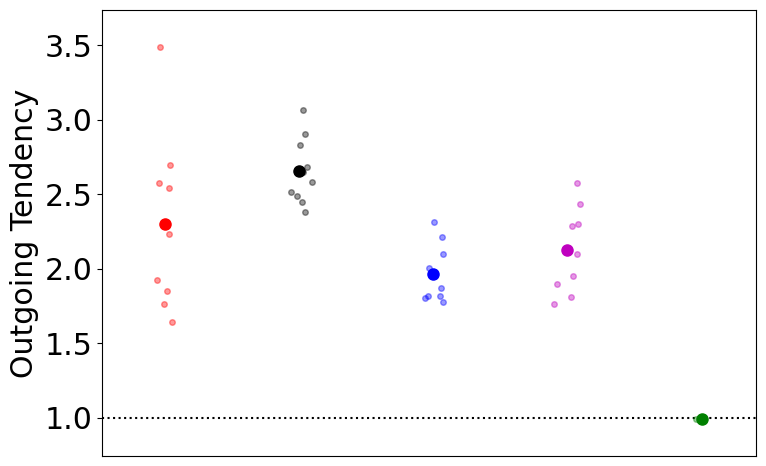

In [77]:
plt.figure(figsize=(8, 5))
ax = plt.gca()

plt.axhline(1, ls=':', c='k')

for i, model_name in enumerate(model_colors):
    print(model_name)
    tfs = load(model_name)
    if not tfs: continue
    ratios = get_oiratio(tfs)
    plt.plot([i+np.random.uniform(-0.1, 0.1) for _ in range(len(ratios))], ratios, f'{model_colors[model_name]}.', markersize=8, alpha=0.4)
    mean_ratio = np.mean(ratios)
    plt.plot(i, mean_ratio, f'{model_colors[model_name]}.', markersize=16, alpha=1)

plt.xticks([])
ax.tick_params(axis='both', labelsize='large')
plt.ylabel('Outgoing Tendency', fontsize='large')
plt.margins(0.1)
plt.tight_layout()
plt.savefig('../../figs/paper figs/figure_results/oiratio.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()